# Automatic Google search of venue images

In [0]:
CITY = 'ORLANDO'

In [1]:
!pip install google_images_download

     |████████████████████████████████| 911kB 13.7MB/s 
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=14550 sha256=be5312eeae41908dfbf3afe728d811686ccda2c8a8eefb6798aea1d81feb7e6b
  Stored in directory: /root/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download


In [0]:
import pandas as pd
import numpy as np
from google_images_download import google_images_download

In [3]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [7]:
from google.colab import files
uploaded = files.upload()

Saving predicthq_export - Orlando - Ralph Lauren.csv to predicthq_export - Orlando - Ralph Lauren.csv


In [0]:
events = pd.read_csv("predicthq_export - Orlando - Ralph Lauren.csv")

In [9]:
events.head(5)

,id,title,description,start,end,predicted_end,duration,labels,category,timezone,country,location,venue_name,venue_formatted_address,scope,rank,local_rank,aviation_rank,state,first_seen
0,tNCvM9eaqq7KgfvtaC,Screamin' Green Hauntoween,"""Spooky and colorful family fun awaits during ...",2016-10-08T14:00:00Z,2016-10-09T00:00:00Z,NaN,36000,"""attraction,community,family""",community,America/New_York,US,"""28.444559,-81.391691""",Crayola Experience,8001 S Orange Blossom Trl\nSouth Orange Blosso...,locality,24,45.0,NaN,active,2018-01-31T17:54:29Z
1,lxgv6VgLXele,Moderate Delays - Orlando International Airpor...,NaN,2016-10-08T21:30:00Z,2016-10-09T00:30:00Z,NaN,10800,"""airport,delay""",airport-delays,America/New_York,US,"""28.43126,-81.307509""",Hyatt Regency Orlando International Airport,"9300 Jeff Fuqua Boulevard\nOrlando, FL 32827\n...",locality,40,NaN,NaN,active,2016-10-08T01:55:49Z
2,030e6833f057d76d21,Leif Erikson Day,"""Leif Erikson Day honors the first Scandinavia...",2016-10-09T00:00:00Z,2016-10-09T23:59:59Z,NaN,86399,"""holiday,observance""",observances,NaN,US,"""37.09024,-95.712891""",Leif Erikson Day,NaN,country,50,NaN,0.0,active,2015-01-06T12:35:08Z
3,8MwekkdMl77j,Henry Rollins (21+),NaN,2016-10-09T00:00:00Z,2016-10-09T00:00:00Z,NaN,0,"""concert,music""",concerts,America/New_York,US,"""28.548701,-81.351256""",The Plaza Live,"425 North Bumby Avenue\nOrlando, FL 32803\nUni...",locality,49,72.0,0.0,active,2016-09-13T04:56:15Z
4,D5jGBJZzGdpN,The Illusionists,NaN,2016-10-09T00:00:00Z,2016-10-09T00:00:00Z,NaN,0,"""performing-arts""",performing-arts,America/New_York,US,"""28.537531,-81.376895""",Dr. Phillips Center - Walt Disney Theater,"445 South Magnolia Avenue\nOrlando, FL 32801\n...",locality,59,77.0,NaN,active,2016-06-10T21:57:50Z


In [10]:
events.shape

(25379, 20)

In [11]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25379 entries, 0 to 25378
Data columns (total 20 columns):
id                         25379 non-null object
title                      25379 non-null object
description                16916 non-null object
start                      25379 non-null object
end                        25379 non-null object
predicted_end              720 non-null object
duration                   25379 non-null int64
labels                     25379 non-null object
category                   25379 non-null object
timezone                   24388 non-null object
country                    25376 non-null object
location                   25379 non-null object
venue_name                 23715 non-null object
venue_formatted_address    22648 non-null object
scope                      25379 non-null object
rank                       25379 non-null int64
local_rank                 23376 non-null float64
aviation_rank              10960 non-null float64
state      

In [12]:
events['venue_id'] = events.groupby('venue_name').ngroup()
events.head(2)

,id,title,description,start,end,predicted_end,duration,labels,category,timezone,country,location,venue_name,venue_formatted_address,scope,rank,local_rank,aviation_rank,state,first_seen,venue_id
0,tNCvM9eaqq7KgfvtaC,Screamin' Green Hauntoween,"""Spooky and colorful family fun awaits during ...",2016-10-08T14:00:00Z,2016-10-09T00:00:00Z,NaN,36000,"""attraction,community,family""",community,America/New_York,US,"""28.444559,-81.391691""",Crayola Experience,8001 S Orange Blossom Trl\nSouth Orange Blosso...,locality,24,45.0,NaN,active,2018-01-31T17:54:29Z,188
1,lxgv6VgLXele,Moderate Delays - Orlando International Airpor...,NaN,2016-10-08T21:30:00Z,2016-10-09T00:30:00Z,NaN,10800,"""airport,delay""",airport-delays,America/New_York,US,"""28.43126,-81.307509""",Hyatt Regency Orlando International Airport,"9300 Jeff Fuqua Boulevard\nOrlando, FL 32827\n...",locality,40,NaN,NaN,active,2016-10-08T01:55:49Z,375


In [13]:
events.venue_id.nunique()

991

In [0]:
venue = pd.DataFrame(events[['venue_name', 'venue_id']].drop_duplicates(['venue_id']).dropna())
venue['venue_type'] = ''

In [15]:
len(venue)

990

In [16]:
venue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 0 to 25212
Data columns (total 3 columns):
venue_name    990 non-null object
venue_id      990 non-null int64
venue_type    990 non-null object
dtypes: int64(1), object(2)
memory usage: 30.9+ KB


In [17]:
venue[venue['venue_name'].str.contains(',')]

,venue_name,venue_id,venue_type
984,"Fields BMW, Winter Park",285,
3153,"Aero, The Patio, Old 64",35,
3987,"Valencia College, School of Public Safety",856,
5245,"I-Drive 360, Home of the Coca-Cola Orlando Eye",378,
14382,"Castle Hotel, Autograph Collection",132,
14519,"Righteous Foundation International Ministries,...",677,
18109,"Purple, Rock, Scissors",657,
18204,"Music Plaza Stage, Universal Studios Orlando",552,
18434,Holiday Inn Orlando Airport 5750 T.G. Lee Boul...,360,
18537,"Comparative Drama Conference, April 5-7, 2018,...",173,


In [0]:
# events.to_csv('venue.csv', columns=['venue_name'], index=False)
# Replace ',' with ' ' for search by keywords, which requires separation
# of keywords by ','
venue['new_venue_name'] = venue['venue_name'].str.replace(',', ' ')
venue_name = venue['new_venue_name'].str.cat(sep=',')

In [19]:
venue.head(3)

,venue_name,venue_id,venue_type,new_venue_name
0,Crayola Experience,188,,Crayola Experience
1,Hyatt Regency Orlando International Airport,375,,Hyatt Regency Orlando International Airport
2,Leif Erikson Day,498,,Leif Erikson Day


In [20]:
len(venue_name.split(','))

990

In [0]:
import pathlib
import shutil
import os

# Remove directories if exist
image_dir = pathlib.Path('/content/downloads')
if os.path.isdir(image_dir):
  shutil.rmtree(image_dir)

In [22]:
# Class instantiation
response = google_images_download.googleimagesdownload()   

# Create dictionary of arguments
arguments = {"keywords":venue_name, 
            #  "usage_rights":"labeled-for-reuse-with-modifications",
             "limit":1,
             "format":"jpg",
             "color_type":"full-color",
             "type":"photo",
             "size":"medium",
             "silent_mode":True
             }   
paths = response.download(arguments)  

# Places365-CNN for classifying venue images

In [23]:
!pip install Pillow

In [0]:
# https://github.com/CSAILVision/places365/blob/master/run_placesCNN_unified.py
# Demo: http://places2.csail.mit.edu/demo.html
# PlacesCNN to predict the scene category, attribute, and 
# class activation map in a single pass
# by Bolei Zhou, sep 2, 2017

import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
# from scipy.misc import imresize as imresize
import cv2
from PIL import Image


def load_labels():
    # prepare all the labels
    # scene category relevant
    file_name_category = 'categories_places365.txt'
    if not os.access(file_name_category, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    with open(file_name_category) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
    classes = tuple(classes)

    # indoor and outdoor relevant
    file_name_IO = 'IO_places365.txt'
    if not os.access(file_name_IO, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
        os.system('wget ' + synset_url)
    with open(file_name_IO) as f:
        lines = f.readlines()
        labels_IO = []
        for line in lines:
            items = line.rstrip().split()
            labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
    labels_IO = np.array(labels_IO)

    # scene attribute relevant
    file_name_attribute = 'labels_sunattribute.txt'
    if not os.access(file_name_attribute, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt'
        os.system('wget ' + synset_url)
    with open(file_name_attribute) as f:
        lines = f.readlines()
        labels_attribute = [item.rstrip() for item in lines]
    file_name_W = 'W_sceneattribute_wideresnet18.npy'
    if not os.access(file_name_W, os.W_OK):
        synset_url = 'http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy'
        os.system('wget ' + synset_url)
    W_attribute = np.load(file_name_W)

    return classes, labels_IO, labels_attribute, W_attribute

def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

# def returnCAM(feature_conv, weight_softmax, class_idx):
#     # generate the class activation maps upsample to 256x256
#     size_upsample = (256, 256)
#     nc, h, w = feature_conv.shape
#     output_cam = []
#     for idx in class_idx:
#         cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
#         cam = cam.reshape(h, w)
#         cam = cam - np.min(cam)
#         cam_img = cam / np.max(cam)
#         cam_img = np.uint8(255 * cam_img)
#         output_cam.append(imresize(cam_img, size_upsample))
#     return output_cam

def returnTF():
# load the image transformer
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf


def load_model():
    # this model has a last conv feature map as 14x14

    model_file = 'wideresnet18_places365.pth.tar'
    if not os.access(model_file, os.W_OK):
        os.system('wget http://places2.csail.mit.edu/models_places365/' + model_file)
        os.system('wget https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py')

    import wideresnet
    model = wideresnet.resnet18(num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    model.eval()



    # the following is deprecated, everything is migrated to python36

    ## if you encounter the UnicodeDecodeError when use python3 to load the model, add the following line will fix it. Thanks to @soravux
    #from functools import partial
    #import pickle
    #pickle.load = partial(pickle.load, encoding="latin1")
    #pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
    #model = torch.load(model_file, map_location=lambda storage, loc: storage, pickle_module=pickle)

    model.eval()
    # hook the feature extractor
    features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    return model

In [0]:
# load the labels
classes, labels_IO, labels_attribute, W_attribute = load_labels()

# load the model
features_blobs = []
model = load_model()

# load the transformer
tf = returnTF() # image transformer

# get the softmax weight
params = list(model.parameters())
weight_softmax = params[-2].data.numpy()
weight_softmax[weight_softmax<0] = 0

In [26]:
all_image_paths = list(image_dir.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths[:5]

['/content/downloads/International Day of Women and Girls in Science/1.Celebrating-International-Day-of-Women-and-Girls-in-Science_OPTIMIZED-870x484.jpg',
 '/content/downloads/Church of the Good Shepherd/1.church-of-the-good-shepherd.jpg',
 '/content/downloads/East End Market/1.EEM-Front-Evenign-Image.jpg',
 '/content/downloads/Orlando Live Events/1.Square-Amp.jpg',
 '/content/downloads/International Day to End Obstetric Fistula/1.featured-image-index-sm.jpg']

In [27]:
len(all_image_paths)
# Some venue images are unavailable.

861

In [0]:
all_image_venues = list(image_dir.glob('*/*'))
all_image_venues = [str(path.parts[3]) for path in all_image_venues]

In [29]:
all_image_venues[:5]

['International Day of Women and Girls in Science',
 'Church of the Good Shepherd',
 'East End Market',
 'Orlando Live Events',
 'International Day to End Obstetric Fistula']

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image(all_image_paths=all_image_paths,
                  all_image_venues=all_image_venues):

  for i in range(5):
    img_path = all_image_paths[i]
    img = mpimg.imread(img_path)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()
  
    print(all_image_venues[i])

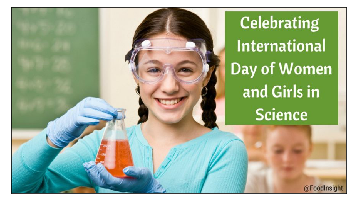

International Day of Women and Girls in Science


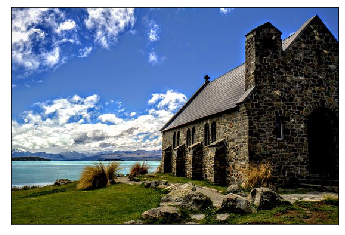

Church of the Good Shepherd


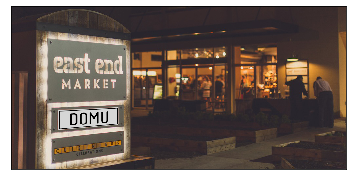

East End Market


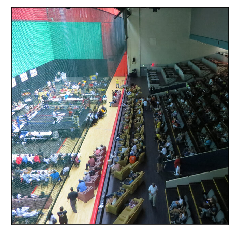

Orlando Live Events


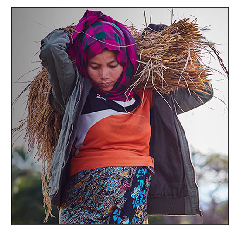

International Day to End Obstetric Fistula


In [31]:
display_image()

In [32]:
for i in range(len(all_image_paths)):
  # load the test image
  try:
    img = Image.open(all_image_paths[i])
    input_img = V(tf(img).unsqueeze(0))

    # forward pass
    logit = model.forward(input_img)
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()

    # output the IO prediction
    io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
    if io_image < 0.5:
      venue.loc[venue.new_venue_name == all_image_venues[i], ['venue_type']] = 'indoor'
    else:
      venue.loc[venue.new_venue_name == all_image_venues[i], ['venue_type']] = 'outdoor'
      
  except Exception:
    print('Broken image', all_image_paths[i])

Broken image /content/downloads/World Autoimmune / Autoinflammatory Arthritis Day
Broken image /content/downloads/Fairfield Inn & Suites by Marriott Orlando International Drive/Convention Center


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Broken image /content/downloads/World Habitat Day/1.world-habitat-day_31012.jpg
Broken image /content/downloads/National POW/MIA Recognition Day
Broken image /content/downloads/Tu Bishvat/Tu B'Shevat
Broken image /content/downloads/Hampton Inn & Suites Orlando North/Altamonte Springs
Broken image /content/downloads/The Alfond Inn/Hamilton's Kitchen
Broken image /content/downloads/Shrove Tuesday/Mardi Gras
Broken image /content/downloads/Chanukah/Hanukkah (first day)
Broken image /content/downloads/Diwali/Deepavali
Broken image /content/downloads/Eid ul-Fitr 2018/1439 Prayer and Celebration
Broken image /content/downloads/Soundbar/1.141299-speakers-review-samsung-hw-ms650-image1-kvwalpna3d.jpg
Broken image /content/downloads/Hilton Orlando/Altamonte Springs


In [0]:
# Fill empty strings with nan
venue = venue.replace(r'^\s*$', np.nan, regex=True)

In [34]:
venue.head(10)

,venue_name,venue_id,venue_type,new_venue_name
0,Crayola Experience,188,indoor,Crayola Experience
1,Hyatt Regency Orlando International Airport,375,NaN,Hyatt Regency Orlando International Airport
2,Leif Erikson Day,498,NaN,Leif Erikson Day
3,The Plaza Live,787,indoor,The Plaza Live
4,Dr. Phillips Center - Walt Disney Theater,228,indoor,Dr. Phillips Center - Walt Disney Theater
5,Winter Garden MusicFest,888,indoor,Winter Garden MusicFest
6,Back Booth,73,indoor,Back Booth
7,World Post Day,945,outdoor,World Post Day
9,Aloma Bowl,45,indoor,Aloma Bowl
10,AMC Universal Cineplex 20 with IMAX (Orlando),27,indoor,AMC Universal Cineplex 20 with IMAX (Orlando)


In [35]:
venue[venue['venue_type'].isnull()]

,venue_name,venue_id,venue_type,new_venue_name
1,Hyatt Regency Orlando International Airport,375,NaN,Hyatt Regency Orlando International Airport
2,Leif Erikson Day,498,NaN,Leif Erikson Day
13,Firebirds Wood Fired Grill,286,NaN,Firebirds Wood Fired Grill
14,Soundbar,721,NaN,Soundbar
33,Dr. Phillips Center for the Performing Arts,229,NaN,Dr. Phillips Center for the Performing Arts
...,...,...,...,...
22335,"The American Legion, Department of Florida",764,NaN,The American Legion Department of Florida
23424,Florida Science Olympiad,303,NaN,Florida Science Olympiad
23569,Hilton Garden Inn Orlando Airport,352,NaN,Hilton Garden Inn Orlando Airport
24769,The Alfond Inn/Hamilton's Kitchen,763,NaN,The Alfond Inn/Hamilton's Kitchen


# Some NLPs to fill NA's / reclassify

## Top 150 tagging

In [0]:
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
# Flatten into a list
tokens = venue.apply(lambda x: nltk.word_tokenize(x['venue_name']), axis=1).sum()
tags = nltk.pos_tag(tokens)

In [0]:
nouns = [token[0] for token in tags if token[1] == 'NNP']
frequency = nltk.FreqDist(nouns)
top_150 = frequency.most_common(150)

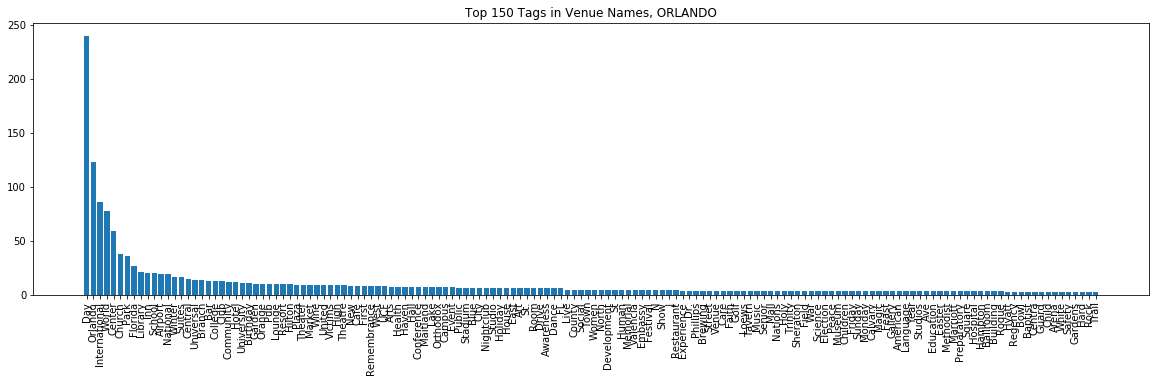

In [40]:
plt.figure(figsize=(20, 5))
plt.bar(range(len(top_150)), [val[1] for val in top_150], align='center')
plt.xticks(range(len(top_150)), [val[0] for val in top_150])
plt.xticks(rotation=90)
plt.title('Top 150 Tags in Venue Names, ' + CITY)
plt.savefig('Top 150 Tags in Venue Names, ' + CITY + '.jpg')
plt.show()

In [41]:
[val[0] for val in top_150]

['Day',
 'Orlando',
 'International',
 'World',
 'Center',
 'Church',
 'Park',
 'Florida',
 'Library',
 'Inn',
 'School',
 'Airport',
 'National',
 'Winter',
 'Suites',
 'Central',
 'Universal',
 'Branch',
 'Bar',
 'College',
 'Club',
 'Community',
 'Hotel',
 'University',
 'Birthday',
 'Garden',
 'Orange',
 'Pub',
 'Lounge',
 'Resort',
 'Hilton',
 'Plaza',
 'Theater',
 'Market',
 'Wine',
 'United',
 'Victims',
 'High',
 'Theatre',
 'New',
 'Cafe',
 'First',
 'Remembrance',
 'West',
 'UCF',
 'Arts',
 'Health',
 'Haven',
 'Hall',
 'Conference',
 'Maitland',
 'Lake',
 'Orthodox',
 'Campus',
 'Event',
 'Public',
 'Stadium',
 'Blue',
 'City',
 'Nightclub',
 'Studio',
 'Holiday',
 'House',
 'East',
 'Art',
 'St.',
 'Room',
 'Drive',
 'Awareness',
 'Dance',
 'FL',
 'Live',
 'County',
 'Social',
 'Town',
 'Women',
 'North',
 'Development',
 'St',
 'Human',
 'Memorial',
 'Valencia',
 'Embassy',
 'Festival',
 'N',
 'Show',
 '|',
 'Restaurant',
 'Experience',
 'Dr.',
 'Phillips',
 'Brewing',
 'S

In [0]:
indoor_word_list = ['Center', 'Church', 'Library', 'Inn', 'School', 'Airport', \
                    'Bar', 'College', 'Club', 'Hotel', 'University', 'Pub', \
                    'Lounge', 'Resort', 'Hilton', 'Plaza', 'Theater', 'Market', \
                    'Theatre', 'Cafe', 'UCF', 'Haven', 'Hall', 'Conference', \
                    'Campus', 'Stadium', 'Nightclub', 'Studio', 'House', 'Room', \
                    'Restaurant', 'Tavern', 'Mall', 'Sheraton', 'Museum', 'Gallery', \
                    'Marriott', 'Hospital', 'Ballroom', 'Building', 'Hyatt', 'Arena']
outdoor_word_list = ['Park', 'Garden', 'Lake', 'Golf', 'Day', 'Field', 'Square']
# 'County', 'Town'

In [0]:
import inflect
# Obtain the plurals for the words
engine = inflect.engine() # case-sensitive
indoor_word_list_pl = [engine.plural(w.lower()) for w in indoor_word_list]
outdoor_word_list_pl = [engine.plural(w.lower()) for w in outdoor_word_list]

In [0]:
# Case-insensitive
indoor_list = [s.lower() for s in indoor_word_list + indoor_word_list_pl]
outdoor_list = [s.lower() for s in outdoor_word_list + outdoor_word_list_pl]

## Reclassification

In [0]:
def compare_venue_type(df, indoor_list=indoor_list, outdoor_list=outdoor_list):
  # Compute count of substrings in indoor_list/outdoor_list
  # e.g., 'Spa Ravella at Hilton Lake Las Vegas' will have 
  # indoor_cnt = 2 and outdoor_cnt = 1, thus will be classified as 'indoor'
  indoor_cnt = sum(map(lambda x: x.lower() in indoor_list, df['new_venue_name'].split(' ')))
  outdoor_cnt = sum(map(lambda x: x.lower() in outdoor_list, df['new_venue_name'].split(' ')))
  
  return 'indoor' if indoor_cnt >= outdoor_cnt else 'outdoor'

In [0]:
venue['venue_type'] = venue.apply(compare_venue_type, axis=1)

In [47]:
venue.head(10)

,venue_name,venue_id,venue_type,new_venue_name
0,Crayola Experience,188,indoor,Crayola Experience
1,Hyatt Regency Orlando International Airport,375,indoor,Hyatt Regency Orlando International Airport
2,Leif Erikson Day,498,outdoor,Leif Erikson Day
3,The Plaza Live,787,indoor,The Plaza Live
4,Dr. Phillips Center - Walt Disney Theater,228,indoor,Dr. Phillips Center - Walt Disney Theater
5,Winter Garden MusicFest,888,outdoor,Winter Garden MusicFest
6,Back Booth,73,indoor,Back Booth
7,World Post Day,945,outdoor,World Post Day
9,Aloma Bowl,45,indoor,Aloma Bowl
10,AMC Universal Cineplex 20 with IMAX (Orlando),27,indoor,AMC Universal Cineplex 20 with IMAX (Orlando)


- What are left?

In [48]:
venue[venue['venue_type'].isnull()]

,venue_name,venue_id,venue_type,new_venue_name


In [49]:
venue.venue_type.value_counts()

indoor     711
outdoor    279
Name: venue_type, dtype: int64

- Most of the events have the type `indoor`. We will set it as default for the rest.

In [0]:
venue.loc[venue['venue_type'].isnull(),  ['venue_type']] = 'indoor'

# Output

In [50]:
venue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 0 to 25212
Data columns (total 4 columns):
venue_name        990 non-null object
venue_id          990 non-null int64
venue_type        990 non-null object
new_venue_name    990 non-null object
dtypes: int64(1), object(3)
memory usage: 38.7+ KB


In [0]:
venue.to_csv('events_' + CITY + '_venues.csv', index=False)

In [0]:
events_new = pd.merge(events, venue[['venue_id', 'venue_type']], 
                      on='venue_id',
                      how='left').drop('venue_id', 1)

In [53]:
events_new.shape

(25379, 21)

In [54]:
events_new.head(3)

,id,title,description,start,end,predicted_end,duration,labels,category,timezone,country,location,venue_name,venue_formatted_address,scope,rank,local_rank,aviation_rank,state,first_seen,venue_type
0,tNCvM9eaqq7KgfvtaC,Screamin' Green Hauntoween,"""Spooky and colorful family fun awaits during ...",2016-10-08T14:00:00Z,2016-10-09T00:00:00Z,NaN,36000,"""attraction,community,family""",community,America/New_York,US,"""28.444559,-81.391691""",Crayola Experience,8001 S Orange Blossom Trl\nSouth Orange Blosso...,locality,24,45.0,NaN,active,2018-01-31T17:54:29Z,indoor
1,lxgv6VgLXele,Moderate Delays - Orlando International Airpor...,NaN,2016-10-08T21:30:00Z,2016-10-09T00:30:00Z,NaN,10800,"""airport,delay""",airport-delays,America/New_York,US,"""28.43126,-81.307509""",Hyatt Regency Orlando International Airport,"9300 Jeff Fuqua Boulevard\nOrlando, FL 32827\n...",locality,40,NaN,NaN,active,2016-10-08T01:55:49Z,indoor
2,030e6833f057d76d21,Leif Erikson Day,"""Leif Erikson Day honors the first Scandinavia...",2016-10-09T00:00:00Z,2016-10-09T23:59:59Z,NaN,86399,"""holiday,observance""",observances,NaN,US,"""37.09024,-95.712891""",Leif Erikson Day,NaN,country,50,NaN,0.0,active,2015-01-06T12:35:08Z,outdoor


In [55]:
events_new.category.unique()

array(['community', 'airport-delays', 'observances', 'concerts',
       'performing-arts', 'festivals', 'expos', 'sports', 'conferences',
       'severe-weather', 'daylight-savings', 'politics',
       'public-holidays', 'school-holidays', 'disasters', 'academic',
       'terror'], dtype=object)

In [0]:
events_new.to_csv('events_' + CITY + '.csv', index=False)

In [0]:
from google.colab import files

In [0]:
files.download('Top 150 Tags in Venue Names, ' + CITY + '.jpg')

In [0]:
files.download('events_' + CITY + '_venues.csv')

In [0]:
files.download('events_' + CITY + '.csv') 

In [0]:
output_zip = 'venue_images_' + CITY + '.zip'

In [68]:
!zip -r $output_zip $image_dir

  adding: content/downloads/ (stored 0%)
  adding: content/downloads/Engelwood Neighborhood Center/ (stored 0%)
  adding: content/downloads/International Day of Women and Girls in Science/ (stored 0%)
  adding: content/downloads/International Day of Women and Girls in Science/1.Celebrating-International-Day-of-Women-and-Girls-in-Science_OPTIMIZED-870x484.jpg (deflated 1%)
  adding: content/downloads/Church of the Good Shepherd/ (stored 0%)
  adding: content/downloads/Church of the Good Shepherd/1.church-of-the-good-shepherd.jpg (deflated 0%)
  adding: content/downloads/East End Market/ (stored 0%)
  adding: content/downloads/East End Market/1.EEM-Front-Evenign-Image.jpg (deflated 8%)
  adding: content/downloads/Orlando Live Events/ (stored 0%)
  adding: content/downloads/Orlando Live Events/1.Square-Amp.jpg (deflated 0%)
  adding: content/downloads/International Day to End Obstetric Fistula/ (stored 0%)
  adding: content/downloads/International Day to End Obstetric Fistula/1.featured-i

In [70]:
files.download(output_zip)

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 37076, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil